# Creation of a classical and more scalable GCN

source: https://colab.research.google.com/github/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb#scrollTo=KkkOolOVh3nR

In [2]:
%load_ext autoreload
%autoreload 2

In [81]:
%reload_ext autoreload

## Create a graph

In [82]:
# commented to avoid unwanted installation
# !pip install git+https://github.com/deepmind/jraph.git
# !pip install flax
# !pip install dm-haiku
# !pip install networkx

In [3]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
from jax import value_and_grad,vmap,jit,jacfwd
from functools import partial 
import jax.numpy as jnp
from jax import random as jran
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from copy import deepcopy
from typing import Any, Callable, Dict, List, Optional, Tuple

In [4]:
import element_mesh_fractal
import element_mesh
import utils

In [5]:
import numpy
print(numpy.version.version)

1.23.5


In [6]:
def build_jraph_graph(l_node_coords,edges,senders,receivers,globals):
    '''
    Build a jraph.GraphsTuple from a
    Args:
    -l_node_coords (list of features in jnp.array type)
    ...
    Returns:
    -graph (jraph.GraphTuple)
    '''
    new_l_node_coords = deepcopy(l_node_coords)
    for i in range(len(new_l_node_coords)):
        if len(new_l_node_coords.shape)==1:
            new_l_node_coords[i] = jnp.expand_dims(new_l_node_coords[i],axis=1)
        
    node_features = jnp.concatenate(new_l_node_coords,axis=-1)

    n_node = jnp.array([node_features.shape[0]])
    n_edge = jnp.array([edges.shape[0]])
    
    graph = jraph.GraphsTuple(
        nodes=node_features,
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=n_node,
        n_edge=n_edge,
        globals=globals
        )
    
    return graph

In [7]:
def convert_elem_mesh2undirected_graph(node_coords,p_elem2nodes,elem2nodes)-> jraph.GraphsTuple:
  node_features = jnp.array(node_coords)

  for idstart in range(p_elem2nodes.shape[0]-1):
    nodes_elem = elem2nodes[p_elem2nodes[idstart]:p_elem2nodes[idstart+1]]
     
    for j_node in range(nodes_elem.shape[0]):
      new_edge = jnp.array([[nodes_elem[j_node],nodes_elem[(j_node+1)%nodes_elem.shape[0]]]])
      if idstart==0 and j_node==0:
        edges = new_edge
      elif not(utils.check_new_row_already_exists_in_matrix(edges,new_edge)):
        edges = jnp.concatenate([edges,new_edge],axis=0)
    
  # undirected graph
  edges = jnp.concatenate([edges,edges[:,::-1]],axis=0)
  senders = edges[:,0]
  receivers = edges[:,1]

  # optinal : add edge features
  edge_features = jnp.zeros((edges.shape[0],))
  for i in range(edges.shape[0]):
    dist = utils.get_norm_L2(node_coords[edges[i,0],:]-node_coords[edges[i,1],:])
    edge_features= edge_features.at[i].set(dist)
  

  
  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([node_coords.shape[0]])
  n_edge = jnp.array([edges.shape[0]])


  graph = jraph.GraphsTuple(
    nodes=node_features,
    edges=edge_features,
    senders=senders,
    receivers=receivers,
    n_node=n_node,
    n_edge=n_edge,
    globals=None
    ) 
  return graph


def build_toy_graph(n_subdivision=2):
  node_coords, _, p_elem2nodes, elem2nodes, boundary2nodes = element_mesh_fractal.set_simple_mesh()
  node_coords, p_elem2nodes, elem2nodes, boundary2nodes = element_mesh_fractal.subdivide_all(node_coords, p_elem2nodes, elem2nodes, boundary2nodes, n_subdivision=n_subdivision)
  graph = convert_elem_mesh2undirected_graph(node_coords,p_elem2nodes,elem2nodes)
  return graph

graph = build_toy_graph(n_subdivision=2)

In [8]:
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
print("Number of nodes",graph.n_node)

# Number of edges
print("Number of edges",graph.n_edge)

# Node features
print("Node features",graph.nodes)

# Edge features
print("Edge features",graph.edges)

# Edges
print("senders",graph.senders)

print("receivers",graph.receivers)

# Graph-level features
print("Graph-level features",graph.globals)

Number of nodes [9]
Number of edges [32]
Node features [[0.  0.  0. ]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [1.  1.  0. ]
 [0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.5 0.5 0. ]
 [1.  0.5 0. ]
 [0.5 1.  0. ]]
Edge features [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25]
senders [0 4 6 5 5 6 8 2 4 1 7 6 6 7 3 8 4 6 5 0 6 8 2 5 1 7 6 4 7 3 8 6]
receivers [4 6 5 0 6 8 2 5 1 7 6 4 7 3 8 6 0 4 6 5 5 6 8 2 4 1 7 6 6 7 3 8]
Graph-level features None


## plot it 

In [9]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  
  
  # edge weight labels
  edge_labels = nx.get_edge_attributes(nx_graph, "edge_feature")
  nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels)

  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')


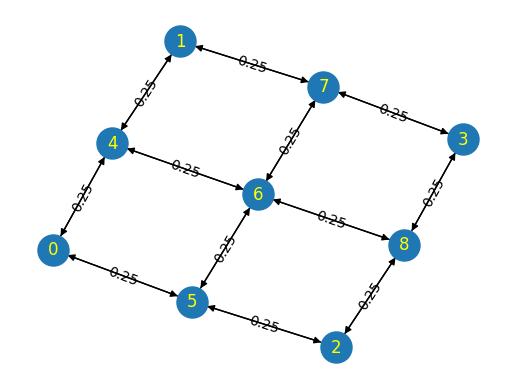

In [10]:
draw_jraph_graph_structure(graph)

## Code GNN

In [11]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features
  # For simplicity, we will first use an identify function here, and replace it
  # with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  out_graph = graph._replace(nodes=nodes)
  return out_graph

graph = build_toy_graph()
out_graph = apply_simplified_gcn(graph)
out_graph.nodes

DeviceArray([[0.5, 0.5, 0. ],
             [1.5, 0.5, 0. ],
             [0.5, 1.5, 0. ],
             [1.5, 1.5, 0. ],
             [2. , 1. , 0. ],
             [1. , 2. , 0. ],
             [4. , 4. , 0. ],
             [3. , 2. , 0. ],
             [2. , 3. , 0. ]], dtype=float32)

In [12]:
class MLP(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))

    mlp = hk.Sequential(layers)
    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(features=[8, 1])(x)

graph = build_toy_graph()
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)
out

DeviceArray([[0.        ],
             [0.2020613 ],
             [0.59043956],
             [0.97206557],
             [0.10103065],
             [0.29521978],
             [0.48603278],
             [0.6566619 ],
             [0.78125256]], dtype=float32)

In [13]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

### One layer

In [14]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = True) -> Callable:
  """Returns a method that applies a Graph Convolution layer.

  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults to
      True.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN

In [15]:
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(features=[8, 1])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[0.10231142],
             [0.26298916],
             [0.47475716],
             [0.6952898 ],
             [0.21728513],
             [0.3564018 ],
             [0.60084593],
             [0.5793976 ],
             [0.7045945 ]], dtype=float32)

### Multiple layers GCN

In [16]:
class GCN(hk.Module):
  """Defines a graph neural network with GCN layers.  """
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features
  
  def __call__(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    layers = []
    for feat in self.features[:-1]:
      layers.append(GraphConvolution(
        update_node_fn=lambda n: jax.nn.tanh(hk.Linear(feat)(n)),
        add_self_edges=True))
    layers.append(GraphConvolution(
      update_node_fn=hk.Linear(self.features[-1])))

    gcn = hk.Sequential(layers)
    return gcn(graph)


# Use GCN model to define the update node function
update_node_fn = lambda x: GCN(features=[8, 1])(x)

graph = build_toy_graph()
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph)
out_graph = update_node_module.apply(params, graph)
out_graph.nodes

DeviceArray([[0.30332157],
             [0.34365693],
             [0.5200698 ],
             [0.56040514],
             [0.45847186],
             [0.6052144 ],
             [0.86372674],
             [0.6703508 ],
             [0.8170934 ]], dtype=float32)

### Solve Poisson equations

In [17]:
def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
  """Solves the karate club problem by optimizing the assignments of students."""
  graph = build_toy_graph()
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), graph)

  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, graph)
    return decoded_graph.nodes

  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, graph)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  # jax_opt instead of optax ?
  opt_init, opt_update,get_params = optax.adam(1e-2) 
  opt_state = opt_init(params)
  
  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

  for step in range(num_steps):
    print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)

  return predict(params)

In [38]:
class PDE_operators2d_graph:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self,function):
        '''
        Args:
        - function : a function taking params and jraph.GraphTuple as args'''
        self.function=function

    # Compute the two dimensional laplacian
    def laplacian_2d(self,params,input_graph):
        fun = lambda params,x,y: self.function(params, input_graph._replace(nodes=jnp.concatenate([x,y],axis=1))).nodes
        @partial(jit)    
        def action(params,x,y):
            u_xx = jacfwd(jacfwd(fun, 1), 1)(params,x,y)
            u_yy = jacfwd(jacfwd(fun, 2), 2)(params,x,y)
            return u_xx + u_yy
        print("came here laplacian 2D")
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        print('came here laplacian 2D 1')
        laplacian = vec_fun(params, input_graph.nodes[:,0:1], input_graph.nodes[:,1:2])
        print('came here laplacian 2D 2')
        return laplacian


############################### Physics Informed Neural Networks ###############################
class PIGNN:
    """
    Solve a PDE using Physics Informed Graph Neural Networks
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self,update_node_fn,not_memorized_graph):
        self.operators=PDE_operators2d_graph(self.solution)
        self.laplacian=self.operators.laplacian_2d
        self.update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
        self.params = update_node_module.init(jax.random.PRNGKey(42), not_memorized_graph)

    # Definition of the function A(x,y) mentioned above
    @partial(jit, static_argnums=(0,))    
    def A_function(self,inputX,inputY):
        return jnp.zeros_like(inputX)

    # Definition of the function F(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def F_function(self,inputX,inputY):
        F1=jnp.multiply(jnp.sin(inputX),jnp.sin(inputX-jnp.ones_like(inputX)))
        F2=jnp.multiply(jnp.sin(inputY),jnp.sin(inputY-jnp.ones_like(inputY)))
        return jnp.multiply(F1,F2).reshape((-1,1))

    # Definition of the function f(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def target_function(self,inputs):
        return 2*jnp.pi**2*jnp.sin(jnp.pi*inputs[:,0:1])*jnp.sin(jnp.pi*inputs[:,1:2])

    # Compute the solution of the PDE on the points (x,y)
    @partial(jit, static_argnums=(0,))    
    def solution(self,input_graph):
        out_graph = self.update_node_module.apply(self.params, input_graph)
        NN = out_graph.nodes

        inputX,inputY = input_graph.nodes[:,0:1],input_graph.nodes[:,1:2]

        F=self.F_function(inputX,inputY)
        A=self.A_function(inputX,inputY)
        return jnp.add(jnp.multiply(F,NN),A)

    # Compute the loss function
    @partial(jit, static_argnums=(0,))    
    def loss_function(self,params,input_graph):
        targets=self.target_function(input_graph.nodes)
        print("came here loss 0")
        preds=self.laplacian(params,input_graph)
        print("came here loss 1")
        return jnp.linalg.norm(preds+targets)/input_graph.nodes.shape[0]   

    # Train step
    # @partial(jit, static_argnums=(0,))    
    def train_step(self, opt_update, opt_state, input_graph):
        print("came here 0")
        loss, grad = value_and_grad(self.loss_function)(self.params,input_graph)
        updates, opt_state = opt_update(grad, opt_state, self.params)
        self.params,opt_state = optax.apply_updates(self.params, updates)
        print("came here 1")
        return loss,self.params,opt_state

    # Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
    def train(self, input_graph: jraph.GraphsTuple, num_train_steps: int) -> Tuple[Dict,hk.Params]:
        """Training loop."""
        # Initialize the optimizer.
        opt_init, opt_update = optax.adam(1e-4)
        opt_state = opt_init(self.params)
        
        history = {"loss":[]}
        for idx in range(num_train_steps):
            loss,self.params,opt_state = self.train_step(opt_update,opt_state, input_graph)
            history["loss"].append(loss)
            if idx % 1 == 0:
                print(f'step: {idx}, loss: {loss}')
        print('Training is over')
        return history, self.params


In [37]:
############################### Initialize neural network ###############################
# Neural network parameters
SEED = 351
n_origin_features, n_targets = 2, 1            # Input and output dimension
features = [n_origin_features,30,n_targets]      # Layers structure

# Initialization
#   Use GCN model to define the update node function
update_node_fn = lambda x: GCN(features=features)(x)

graph = build_toy_graph()
solver=PIGNN(update_node_fn,graph)

In [39]:
solver.train(graph,1)

came here 0
came here loss 0
came here laplacian 2D
came here laplacian 2D 1


ValueError: axis 1 is out of bounds for array of dimension 1

In [ ]:

############################### Train parameters ###############################
batch_size = 50
num_batches = 100000
report_steps=1000
loss_history = []

############################### Adam optimizer ###############################
# It's possible to continue the last training if we use options=1
opt_init, opt_update = optax.adam(1e-2)
opt_state = opt_init(params)


loss_history = []
loss, opt_state = solver.train(input_graph=graph,num_train_steps=1)
loss_history.append(float(loss))



############################### Plot loss function ###############################
fig, ax = plt.subplots(1, 1)
__=ax.plot(loss_history)
xlabel = ax.set_xlabel(r'${\rm Step}$')
ylabel = ax.set_ylabel(r'${\rm (loss_function)}$')
title = ax.set_title(r'${\rm Training}$')
plt.show

############################### Approximated solution ###############################
# We plot the solution obtained with our NN
plt.figure()
params=get_params(opt_state)
n_points=100000
ran_key, batch_key = jran.split(key)
XY_test = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

predictions = solver.solution(params,XY_test[:,0],XY_test[:,1])
plt.scatter(XY_test[:,0],XY_test[:,1], c=predictions, cmap="hot",s=10)
plt.clim(vmin=jnp.min(predictions),vmax=jnp.max(predictions))
plt.colorbar()
plt.title("NN solution")
plt.show()

############################### True solution ###############################
# We plot the true solution, its form was mentioned above
def true_solution(inputs):
    return jnp.sin(jnp.pi*inputs[:,0])*jnp.sin(jnp.pi*inputs[:,1])

plt.figure()
n_points=100000
ran_key, batch_key = jran.split(key)
XY_test = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

true_sol = true_solution(XY_test)
plt.scatter(XY_test[:,0],XY_test[:,1], c=true_sol, cmap="hot",s=10)
plt.clim(vmin=jnp.min(true_sol),vmax=jnp.max(true_sol))
plt.colorbar()
plt.title("True solution")
plt.show()

############################### Absolut error ###############################
# We plot the absolut error, it's |true solution - neural network output|
plt.figure()
params=get_params(opt_state)
n_points=100000
ran_key, batch_key = jran.split(key)
XY_test = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

predictions = solver.solution(params,XY_test[:,0],XY_test[:,1])[:,0]
true_sol = true_solution(XY_test)
error=abs(true_sol-predictions)

plt.scatter(XY_test[:,0],XY_test[:,1], c=error, cmap="viridis",s=10)
plt.clim(vmin=0,vmax=jnp.max(error))
plt.colorbar()
plt.title("Absolut error")
plt.show()